**Ensemble of EfficientNetV2M and NasnetLarge, image resized by following the Central Tendency (to 375,500) trained for 10 Epochs using SGD Optimizer LR = 0.01 with a Validation Accuracy of 95.01%**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import seaborn as sns
%matplotlib inline

import tensorflow as tf

import sklearn

import os
import shutil

In [4]:
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 10222 entries, 0 to 10221

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   id      10222 non-null  object

 1   breed   10222 non-null  object

dtypes: object(2)

memory usage: 159.8+ KB


In [5]:
data = pd.DataFrame(columns = ['filename','label'])

data['filename'] = labels['id'] + '.jpg'
data['label'] = labels['breed']

data.sample(10)

,filename,label
8102,ca6d8156597b78fbf96f9e73b0319f28.jpg,english_foxhound
7213,b4b94f2b42428a8260e67127bdeb4341.jpg,papillon
1898,2ebaa578b5b4680c56ffea593b53cc75.jpg,saluki
1317,209fae9c9a2ec63321399a9b14ae28ec.jpg,briard
4772,77c28f5613c5e7bd0ee27cad00d8e4bd.jpg,malamute
1952,3025810bcca5ca4b08129be3736d2824.jpg,shetland_sheepdog
826,143d5305a4055398828d5b7e3aa8f75b.jpg,great_dane
6790,aa7d9f08fc9ac1d45117848137adce9c.jpg,boston_bull
9576,f056299c0c659aa73947f76837369a9f.jpg,lhasa
3802,5e165d56d2d030a998cab05375f7d5eb.jpg,basenji


In [6]:
batch_size = 64
target_size = (375,500)
input_shape = (375,500,3)

**Defining Image Data Generator and Train Val Datasets**

In [7]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)

In [8]:
train_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,
                                    subset="training")

Found 9200 validated image filenames belonging to 120 classes.


In [9]:
val_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,
                                    subset="validation")

Found 1022 validated image filenames belonging to 120 classes.


In [10]:
efficient_no_top = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top = False, input_shape = input_shape)
nasnet_no_top = tf.keras.applications.nasnet.NASNetLarge(include_top = False, input_shape = input_shape)


214201816/214201816 [==============================] - 2s 0us/step


343610240/343610240 [==============================] - 2s 0us/step


In [11]:
efficient_no_top.input_shape, efficient_no_top.output_shape

((None, 375, 500, 3), (None, 12, 16, 1280))

In [12]:
nasnet_no_top.input_shape, nasnet_no_top.output_shape

((None, 375, 500, 3), (None, 12, 16, 4032))

**Ensembling for feature extraction**

In [13]:
from keras.utils.traceback_utils import include_frame

# 1. Input Layer
input = tf.keras.layers.Input(input_shape, name = "Input_Layer")

# 2. EfficientNetV2M
# 2.1 Preprocessing EfficientNetV2M using Lambda layer
efficient_pre_process = tf.keras.layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input,
                                               name = "EfficientNet_PreProcess") (input)
# 2.2 Get EfficientNetV2M Model
efficient_model = efficient_no_top
efficient_model.trainable = False

# 2.2.1 Pass EfficientNetV2M Model through functional model by linking to preprocess layer
efficient = efficient_model (efficient_pre_process)

# 2.3 Global Average Pooling
efficient_avg = tf.keras.layers.GlobalAveragePooling2D(name="EfficientNetGAP") (efficient)

# 3. NASNetLarge
# 3.1 Preprocessing NASNetLarge using Lambda layer
nasnet_pre_process = tf.keras.layers.Lambda(tf.keras.applications.nasnet.preprocess_input,
                                               name = "Nasnet_PreProcess") (input)
# 3.2 Get NASNetLarge Model
nasnet_model = nasnet_no_top
nasnet_model.trainable = False

# 3.2.1 Pass EfficientNetV2M Model through functional model by linking to preprocess layer
nasnet = nasnet_model (nasnet_pre_process)

# 3.3 Global Average Pooling
nasnet_avg = tf.keras.layers.GlobalAveragePooling2D(name="NASNetGAP") (nasnet)

# 4. Ensemble Features of EfficientNetV2M and NASNetLarge
concat = tf.keras.layers.Concatenate(name = "Concat") ([efficient_avg,nasnet_avg])

# 5. Connecting the Dense and Output Layers
dense1 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_1") (concat)
dense2 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_2") (dense1)
output = tf.keras.layers.Dense(120, activation="softmax", name="Output") (dense2)

In [14]:
# Assembling the Ensemble and Summarizing
final_model = tf.keras.models.Model(inputs= [input],outputs= [output])
final_model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 Input_Layer (InputLayer)       [(None, 375, 500, 3  0           []                               

                                )]                                                                

                                                                                                  

 EfficientNet_PreProcess (Lambd  (None, 375, 500, 3)  0          ['Input_Layer[0][0]']            

 a)                                                                                               

                                                                                                  

 Nasnet_PreProcess (Lambda)     (None, 375, 500, 3)  0           ['Input_Layer[0][0]']            

                                                                                   

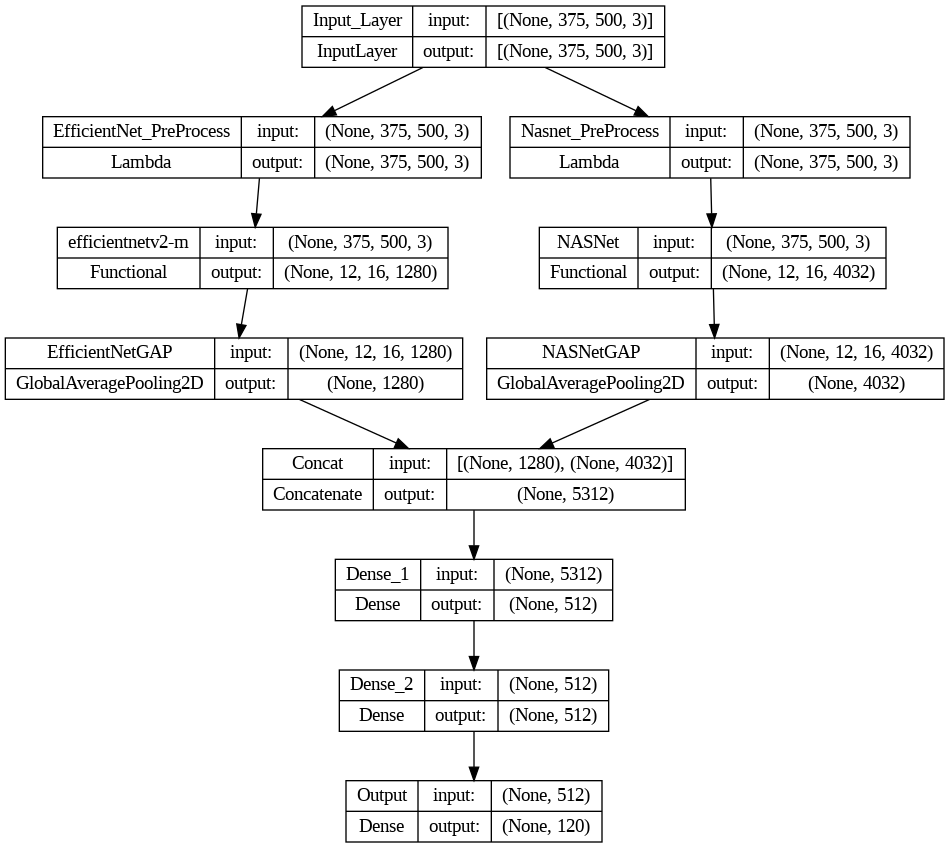

In [15]:
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_names=True)

In [16]:
# Compiling the model
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [17]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                 verbose=0, mode='min')

mcp_save = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True,
                                              monitor='val_loss', mode='min')

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                      patience=3, verbose=1, min_delta=1e-4, mode='min')

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [18]:
%%time
final_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs=10, callbacks = callbacks)

Epoch 1/10

144/144 [==============================] - 927s 6s/step - loss: 4.6762 - acc: 0.1046 - val_loss: 4.5362 - val_acc: 0.2926 - lr: 0.0100

Epoch 2/10

144/144 [==============================] - 828s 6s/step - loss: 4.3597 - acc: 0.5359 - val_loss: 4.1452 - val_acc: 0.7309 - lr: 0.0100

Epoch 3/10

144/144 [==============================] - 832s 6s/step - loss: 3.8548 - acc: 0.7995 - val_loss: 3.5151 - val_acc: 0.8562 - lr: 0.0100

Epoch 4/10

144/144 [==============================] - 832s 6s/step - loss: 3.0853 - acc: 0.8788 - val_loss: 2.6256 - val_acc: 0.8963 - lr: 0.0100

Epoch 5/10

144/144 [==============================] - 827s 6s/step - loss: 2.1221 - acc: 0.9121 - val_loss: 1.6562 - val_acc: 0.9217 - lr: 0.0100

Epoch 6/10

144/144 [==============================] - 831s 6s/step - loss: 1.2547 - acc: 0.9330 - val_loss: 0.9457 - val_acc: 0.9403 - lr: 0.0100

Epoch 7/10

144/144 [==============================] - 832s 6s/step - loss: 0.7318 - acc: 0.9439 - val_loss: 0.5

Text(0.5, 1.0, 'Accuracy of Model')

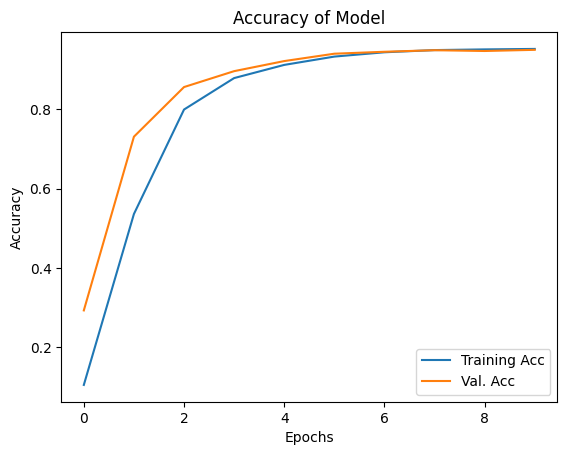

In [19]:
plt.plot(final_model.history.history["acc"], label = "Training Acc")
plt.plot(final_model.history.history["val_acc"], label = "Val. Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model")

Text(0.5, 1.0, 'Loss - Training vs Validation')

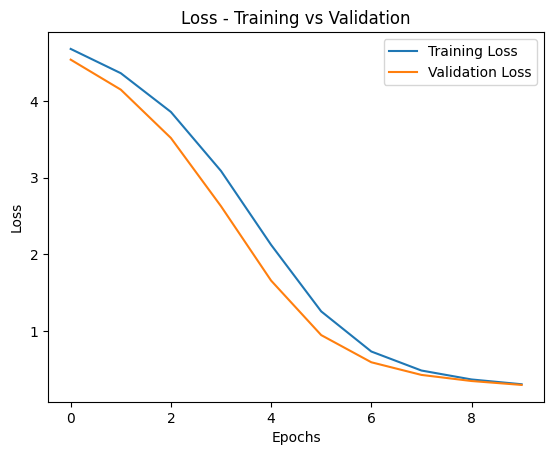

In [20]:
plt.plot(final_model.history.history["loss"], label = "Training Loss")
plt.plot(final_model.history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss - Training vs Validation")

In [21]:
loss = final_model.history.history["loss"]
val_loss = final_model.history.history["val_loss"]
acc = final_model.history.history["acc"]
val_acc = final_model.history.history["val_acc"]

# Create the DataFrame
model_perf = pd.DataFrame({
    "Training_Loss": loss,
    "Validation_Loss": val_loss,
    "Training_Accuracy": acc,
    "Validation_Accuracy": val_acc
})

model_perf.insert(0, "Epoch", range(1, len(model_perf) + 1))

In [22]:
model_perf.to_csv('Ensemble_7.csv',index=False)